In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation

from kurganov_tadmor import *
import utils

### Equation

We solve the Euler equations in 2D 

$$
\begin{equation} 
\partial_t 
\begin{bmatrix} \rho \\ \rho u_x \\ \rho u_y \\ E \end{bmatrix} 
+ 
\partial_x 
\begin{bmatrix} \rho u_x \\ \rho u_x^2 + p \\  \rho u_x u_y \\ (E+p) u_x \end{bmatrix} 
+ 
\partial_y 
\begin{bmatrix} \rho u_y \\ \rho u_y u_x \\  \rho u_y^2 +p \\ (E+p) u_y \end{bmatrix} 
= 0 
\end{equation}
$$

with the equation of state
$$
\begin{equation}
p = (\gamma-1) \left(E-\frac{1}{2} \rho (u_x^2 - u_y^2) \right), \qquad \gamma=1.4
\end{equation}
$$

on the domain $(x,y,t)\in([0,1]\times[0,1]\times[0,0.1])$ with initial data for a *2D Riemann problem*:
$$
\begin{equation}
(\rho, v, p)_{t=0} = 
\begin{cases}
(1,0,1) & \text{if} & 0<x\leq0.5 \\
(0.125, 0, 0.1) & \text{if} & 0.5<x<1
\end{cases}
\end{equation}
$$

and Dirichlet boundary data set by initial data on each boundary. The solution is computed using a 200 $\times$ 200 mesh and CFL number 0.75.

In [2]:
pars = Pars2d(
    x_init=0., x_final=1.,
    y_init=0., y_final=1.,
    J=200, K=200,
    t_final=0.4,
    dt_out=0.005,
    cfl=0.475,
    scheme="fd2",)
pars.gamma = 1.4

In [3]:
# Euler equation
class Euler2d(Equation2d):
    def pressure(self, u):
        return (self.gamma - 1.0) * (
            u[:, :, 3] - 0.5 * (u[:, :, 1] ** 2 + u[:, :, 2] ** 2) / u[:, :, 0]
        )

    def euler_data(self):
        gamma = self.gamma

        p_one = 1.5
        p_two = 0.3
        p_three = 0.029
        p_four = 0.3

        upper_right, upper_left, lower_right, lower_left = np.ones((4, 4))

        upper_right[0] = 1.5
        upper_right[1] = 0.0
        upper_right[2] = 0.0
        upper_right[3] = (
            p_one / (gamma - 1.0)
            + 0.5 * (upper_right[1] ** 2 + upper_right[2] ** 2) / upper_right[0]
        )

        upper_left[0] = 0.5323
        upper_left[1] = 1.206 * upper_left[0]
        upper_left[2] = 0.0
        upper_left[3] = ( p_two / (gamma - 1.0)
            + 0.5 * (upper_left[1] ** 2 + upper_left[2] ** 2) / upper_left[0] )

        lower_right[0] = 0.5323
        lower_right[1] = 0.0
        lower_right[2] = 1.206 * lower_right[0]
        lower_right[3] = ( p_four / (gamma - 1.0)
            + 0.5 * (lower_right[1]**2 + lower_right[2]**2) / lower_right[0] )

        lower_left[0] = 0.138
        lower_left[1] = 1.206 * lower_left[0]
        lower_left[2] = 1.206 * lower_left[0]
        lower_left[3] = ( p_three / (gamma - 1.0)
          + 0.5 * (lower_left[1] ** 2 + lower_left[2] ** 2) / lower_left[0] )

        return upper_right, upper_left, lower_right, lower_left


    def initial_data(self):
        u = np.empty((self.J + 4, self.K + 4, 4))
        midJ = int(self.J / 2) + 2
        midK = int(self.K / 2) + 2

        one_matrix = np.ones(u[midJ:, midK:].shape)
        upper_right, upper_left, lower_right, lower_left = self.euler_data()

        u[midJ:, midK:] = upper_right * one_matrix
        u[:midJ, midK:] = upper_left * one_matrix
        u[midJ:, :midK] = lower_right * one_matrix
        u[:midJ, :midK] = lower_left * one_matrix
        return u

    def boundary_conditions(self, u):

        upper_right, upper_left, lower_right, lower_left = self.euler_data()

        if self.odd:
            j = slice(1, -2)
            u[j, 0] = u[j, 1]
            u[j, -2] = u[j, -3]
            u[j, -1] = u[j, -3]

            u[0, j] = u[1, j]
            u[-2, j] = u[-3, j]
            u[-1, j] = u[-3, j]

            # one
            u[-2, -2] = upper_right
            u[-1, -2] = upper_right
            u[-2, -1] = upper_right
            u[-1, -1] = upper_right

            # two
            u[0, -2] = upper_left
            u[0, -1] = upper_left

            # three
            u[0, 0] = lower_left
            u[0, 1] = lower_left
            u[1, 0] = lower_left
            u[1, 1] = lower_left

            # four
            u[-2, 0] = lower_right
            u[-1, 0] = lower_right
            u[-2, 1] = lower_right
            u[-1, 1] = lower_right

        else:

            j = slice(2, -1)
            u[j, 0] = u[j, 2]
            u[j, 1] = u[j, 2]
            u[j, -1] = u[j, -2]

            u[0, j] = u[2, j]
            u[1, j] = u[2, j]
            u[-1, j] = u[-2, j]

            # one
            u[-1, -2] = upper_right
            u[-1, -1] = upper_right

            # two
            u[0, -2] = upper_left
            u[0, -1] = upper_left
            u[1, -2] = upper_left
            u[1, -1] = upper_left

            # three
            u[0, 0] = lower_left
            u[0, 1] = lower_left
            u[1, 0] = lower_left
            u[1, 1] = lower_left

            # four
            u[-1, 0] = lower_right
            u[-1, 1] = lower_right

    def flux_x(self, u):
        f = np.empty_like(u)

        p = self.pressure(u)

        f[:, :, 0] = u[:, :, 1]
        f[:, :, 1] = u[:, :, 1] ** 2 / u[:, :, 0] + p
        f[:, :, 2] = u[:, :, 1] * u[:, :, 2] / u[:, :, 0]
        f[:, :, 3] = (u[:, :, 3] + p) * u[:, :, 1] / u[:, :, 0]

        return f

    def flux_y(self, u):
        g = np.empty_like(u)

        p = self.pressure(u)

        g[:, :, 0] = u[:, :, 2]
        g[:, :, 1] = u[:, :, 1] * u[:, :, 2] / u[:, :, 0]
        g[:, :, 2] = u[:, :, 2] ** 2 / u[:, :, 0] + p
        g[:, :, 3] = (u[:, :, 3] + p) * u[:, :, 2] / u[:, :, 0]

        return g

    def spectral_radius_x(self, u):

        j0 = utils.j0

        rho = u[j0, j0, 0]
        vx = u[j0, j0, 1] / rho
        vy = u[j0, j0, 2] / rho
        p = (self.gamma - 1.0) * (u[j0, j0, 3] - 0.5 * rho * (vx ** 2 + vy ** 2))
        c = np.sqrt(self.gamma * p / rho)
        return np.abs(vx) + c

    def spectral_radius_y(self, u):

        j0 = utils.j0

        rho = u[j0, j0, 0]
        vx = u[j0, j0, 1] / rho
        vy = u[j0, j0, 2] / rho
        p = (self.gamma - 1.0) * (u[j0, j0, 3] - 0.5 * rho * (vx ** 2 + vy ** 2))
        c = np.sqrt(self.gamma * p / rho)
        return np.abs(vy) + c

### Solution

In [4]:
eqn = Euler2d(pars)
soln = Solver2d(eqn)
soln.solve()

### Animation

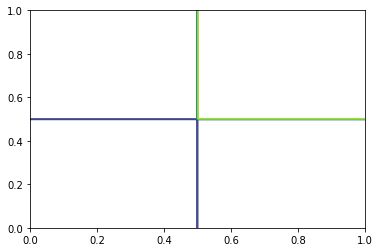

In [5]:
# Animation
fig = plt.figure()
ax = plt.axes(xlim=(soln.x_init,soln.x_final), ylim=(soln.y_init, soln.y_final))

ax.contour(soln.x[1:-1], soln.y[1:-1], soln.u_n[0,1:-1,1:-1,0])
plt.show()

# def animate(i):
#     ax.collections = []
#     ax.contour(soln.x[1:-1], soln.y[1:-1], soln.u_n[i,1:-1,1:-1,0])
    
# plt.close()
# anim = animation.FuncAnimation(fig, animate, frames=soln.Nt, interval=100, blit=False);

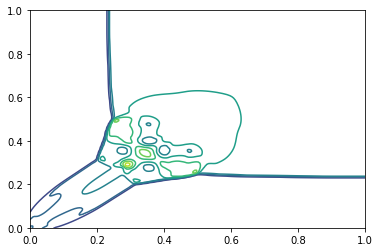

In [7]:
fig = plt.figure()
ax = plt.axes(xlim=(soln.x_init,soln.x_final), ylim=(soln.y_init, soln.y_final))

ax.contour(soln.x[1:-1], soln.y[1:-1], soln.u_n[-1,1:-1,1:-1,-1])
plt.show()